# Assignment 3: Fall Detection

Authors:  
Arin Rahim

## Imports

In [ ]:

# General imports  
#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
#from processes.data_handler import seperate_fall_no_fall_files, seperate_files, load_label_data, extract_all_data 
#from models.lstm_model import create_lstm_model
#from tensorflow.keras.optimizers.legacy import Adam
#from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


## Load data

Firstly, I seperate the sensor files for each subject into a individual array. Secondly, I seperate the fall filles from the non fall files. Thirdly, I store all the label files into an array. Lastly, I extract when the fall occurs from the fall files, which is between a specific range of frame, and merge it together with the rest of the frames, and the non fall data. For each step, I utilize functions that ive created and can be found in the processes folder. 

In [ ]:
# Storing all the sensor data files into an array 
sensor_files = seperate_files()

# Seperating the fall and non-fall files from the sensor_files
fall_files, non_fall_files = seperate_fall_no_fall_files(sensor_files)

# Storing all the label files into an array 
label_files = load_label_data()

# Extracting all the data from the sensor files and label files and creating a merged csv file called 'combined_csv'
extract_all_data_activity = extract_all_data(fall_files, non_fall_files, label_files)

## Task 1: Neural network 

Develop and train your own neural network to detect falls. You can design your own architecture, or rely on LSTM/RNN architectures 

I choose to standarize/normalize the columns that were going to be used as features to minimize the risk of different features having different impact on the models performance . This is because if one feature has a much larger range than another, it may dominate all the other features and cause the model to overfit to that feature. Also without normalization, features with larger scale can potentially lead to a biased model. 

In [143]:
# Create a copy of the data frame 
fall_detection_df = extract_all_data_activity.copy()

# Store the sensor coloumns that is going to be standarized/normalized
sensor_colunmns = ['AccX', 'AccY', 'AccZ', 'GyrX', 'GyrY', 'GyrZ', 'EulerX', 'EulerY', 'EulerZ']

# A standardScaler is initiated
scaler = StandardScaler()

# Fit the scaler to the sensor data
fall_detection_df[sensor_colunmns] = scaler.fit_transform(fall_detection_df[sensor_colunmns])

fall_detection_df.head()

,TimeStamp(s),FrameCounter,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,EulerX,EulerY,EulerZ,Task ID,Trial ID,fall_label
0,0.01,1,-0.205811,-0.580386,-0.090295,-0.339988,-0.087751,0.002970,0.306427,-0.263486,-0.328446,15,01,0
1,0.02,2,-0.202918,-0.582315,-0.084500,-0.346449,-0.107758,0.010926,0.304416,-0.263750,-0.328083,15,01,0
2,0.03,3,-0.211597,-0.586172,-0.082569,-0.331911,-0.131766,0.008274,0.302487,-0.263750,-0.327810,15,01,0
3,0.04,4,-0.226061,-0.617028,-0.105748,-0.341603,-0.145104,-0.004986,0.300559,-0.263750,-0.327720,15,01,0
4,0.05,5,-0.234739,-0.628599,-0.105748,-0.388449,-0.157108,-0.020898,0.297961,-0.263223,-0.327629,15,01,0


## Apply LSTM model 

The features and labels were then seperated and the data is split into training and testing data. The features are the sensor data, while the label is the fall label class represented with 0 and 1 depending on if the subject was falling or not with 0 being non fallen and 1 as fallen. 

In [212]:
X = fall_detection_df.drop(['TimeStamp(s)', 'FrameCounter', 'Task ID', 'Trial ID', 'fall_label'], axis=1) # features 
y = fall_detection_df['fall_label'] # label 

# Split the data set to train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Neural networks, such as LSTM networks, excpet input data to include the timestamp, samples, and features. By reshaping the train data and test data accordingly, the LSTM model could intepret the input data correctly. I decided the specifiy the LSTM model with two layers with 50 and 30 neurons, to capture data and maintain a balance to prevent overfitting. The dropout rates were set to 0.2 to furthur increase our chance to avoid overfitting. For this specific model, optimizer  was chosen as Adam which is known for its efficiency in training deep neural network models.

In [259]:
# Adding samples, timestep, and labels
X_train_reshape = X_train.to_numpy().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshape = X_test.to_numpy().reshape(X_test.shape[0], 1, X_test.shape[1])

# Specify the models arcitechure 
input_shape = X_train_reshape.shape[1:]
lstm_units = [50, 30]
dense_units = [20, 10]
lstm_dropout = 0.2
dense_dropout = 0.2
output_activation = 'sigmoid'

# create the model 
lstm_model_task1 = create_lstm_model(input_shape, lstm_units, dense_units, lstm_dropout, dense_dropout, output_activation)

# compile the model 
lstm_model_task1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

The number of epochs were set to 10, and the batch size to 32. 

In [271]:
# Train the model 
history_task1 = lstm_model_task1.fit(X_train_reshape, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshape, y_test), verbose=1)

Epoch 1/10
99878/99878 [==============================] - 140s 1ms/step - loss: 0.0544 - accuracy: 0.9804 - val_loss: 0.0458 - val_accuracy: 0.9832
Epoch 2/10
99878/99878 [==============================] - 136s 1ms/step - loss: 0.0540 - accuracy: 0.9806 - val_loss: 0.0461 - val_accuracy: 0.9832
Epoch 3/10
99878/99878 [==============================] - 137s 1ms/step - loss: 0.0534 - accuracy: 0.9809 - val_loss: 0.0456 - val_accuracy: 0.9833
Epoch 4/10
99878/99878 [==============================] - 136s 1ms/step - loss: 0.0534 - accuracy: 0.9809 - val_loss: 0.0450 - val_accuracy: 0.9835
Epoch 5/10
99878/99878 [==============================] - 137s 1ms/step - loss: 0.0530 - accuracy: 0.9809 - val_loss: 0.0455 - val_accuracy: 0.9834
Epoch 6/10
99878/99878 [==============================] - 137s 1ms/step - loss: 0.0531 - accuracy: 0.9810 - val_loss: 0.0448 - val_accuracy: 0.9835
Epoch 7/10
99878/99878 [==============================] - 139s 1ms/step - loss: 0.0527 - accuracy: 0.9811 - val_

In [272]:
# Evalute the model 
test_loss_task1, test_accuracy_task1 = lstm_model_task1.evaluate(X_test_reshape, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy_task1}, Test loss: {test_loss_task1}")


Test accuracy: 0.9837501049041748, Test loss: 0.044337574392557144


In [273]:
# Classification report of the model 1 on the test data
prediction_prob_task1 = lstm_model_task1.predict(X_test_reshape)
prediction_task1 = (prediction_prob_task1 > 0.5).astype("int32")
print("Classification report of the model 2: \n", classification_report(y_test, prediction_task1))

24970/24970 [==============================] - 13s 523us/step
Classification report of the model 2: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    764438
           1       0.85      0.76      0.80     34582

    accuracy                           0.98    799020
   macro avg       0.92      0.88      0.90    799020
weighted avg       0.98      0.98      0.98    799020



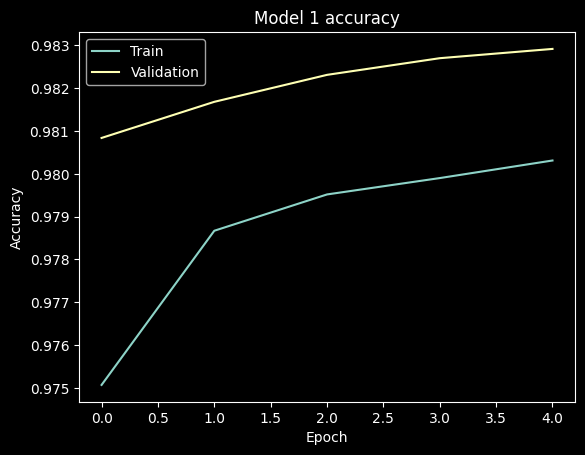

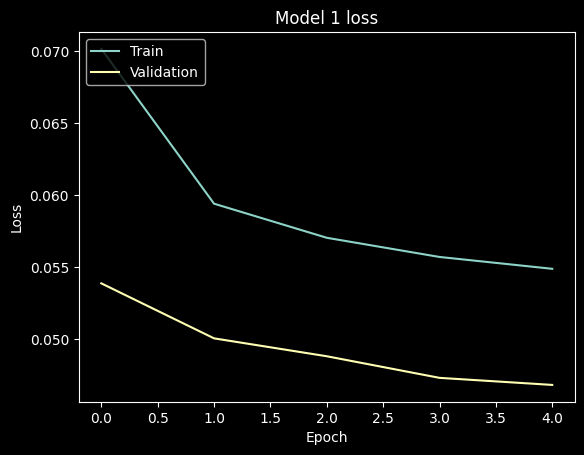

In [262]:

# Plot training & validation accuracy values
plt.plot(history_task1.history['accuracy'])
plt.plot(history_task1.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_task1.history['loss'])
plt.plot(history_task1.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Task 2: Traning strategy 

Design and apply a training strategy. Motivate your choices for epochs, batch sizes, dropouts, stopping methods and optimizers. 

For the traning strategy, choosing appropriate values for epochs, batch size, and dropouts is crucial for the traning process and impacts the models performance and efficency. The epochs is the number of times the traning data will be passed forward and backward throught the neural network. A high value can lead to better performance but  also increase the risk of overfitting. Batch size refers to how many samples are sent to the model for training in one iteration. A larger batch size can make the training process faster but may require more memory. Dropout is a regularization technique that helps prevent over-fitting by randomly ignoring a subset of neurons during traning. The parameters size have been selected to be different than in task 1 to see if that will result in better model peformance(e.g. added a new layer with x number of neurons or increasing the dropout) Ive also integrated a early stopping to avoid overfitting with patience value 4.

In [263]:
# Specify the models architecture 
input_shape_task2 = X_train_reshape.shape[1:]
lstm_units_task2 = [50, 40, 30]
dense_units_task2 = [20, 15, 10]
lstm_dropout_task2 = 0.3
dense_dropout_task2 = 0.3
output_activation_task2 = 'sigmoid'

# Create a new model 
lstm_model_task2 = create_lstm_model(input_shape_task2, lstm_units_task2, dense_units_task2, lstm_dropout_task2, dense_dropout_task2, output_activation_task2)

# Compile the model 
lstm_model_task2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history_task2 = lstm_model_task2.fit(
    X_train_reshape, y_train,
    epochs=10,  
    batch_size=64,  
    validation_data=(X_test_reshape, y_test),  
    verbose = 1,
    callbacks=[early_stopping]  
)


Epoch 1/10
49939/49939 [==============================] - 121s 2ms/step - loss: 0.0833 - accuracy: 0.9709 - val_loss: 0.0584 - val_accuracy: 0.9787
Epoch 2/10
49939/49939 [==============================] - 110s 2ms/step - loss: 0.0681 - accuracy: 0.9752 - val_loss: 0.0543 - val_accuracy: 0.9808
Epoch 3/10
49939/49939 [==============================] - 111s 2ms/step - loss: 0.0652 - accuracy: 0.9766 - val_loss: 0.0525 - val_accuracy: 0.9815
Epoch 4/10
49939/49939 [==============================] - 111s 2ms/step - loss: 0.0638 - accuracy: 0.9773 - val_loss: 0.0512 - val_accuracy: 0.9817
Epoch 5/10
49939/49939 [==============================] - 164s 3ms/step - loss: 0.0628 - accuracy: 0.9775 - val_loss: 0.0500 - val_accuracy: 0.9821
Epoch 6/10
49939/49939 [==============================] - 115s 2ms/step - loss: 0.0622 - accuracy: 0.9778 - val_loss: 0.0490 - val_accuracy: 0.9822
Epoch 7/10
49939/49939 [==============================] - 114s 2ms/step - loss: 0.0614 - accuracy: 0.9781 - val_

In [288]:
# Evaluate the model on the test set
test_loss_task2, test_accuracy_task2 = lstm_model_task2.evaluate(X_test_reshape, y_test, verbose=0)
print(f"Test accuracy model 2: {test_accuracy_task2}, Test loss model 2: {test_loss_task2}")

Test accuracy model 2: 0.9825010895729065, Test loss model 2: 0.04859262704849243


In [269]:
# Classification report of the model 2 on test set
prediction_prob_task2 = lstm_model_task2.predict(X_test_reshape)
prediction_task2 = (prediction_prob_task2 > 0.5).astype("int32")
print("Classification report of the model 2 on test set: \n", classification_report(y_test, prediction_task2))


24970/24970 [==============================] - 16s 640us/step
Classification report of the model 2 on test set: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    764438
           1       0.88      0.69      0.77     34582

    accuracy                           0.98    799020
   macro avg       0.93      0.84      0.88    799020
weighted avg       0.98      0.98      0.98    799020



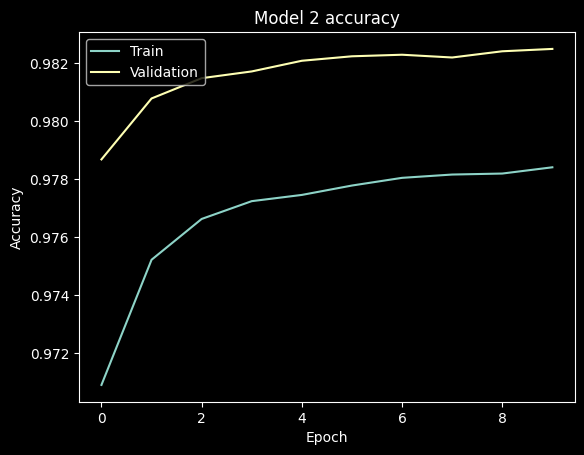

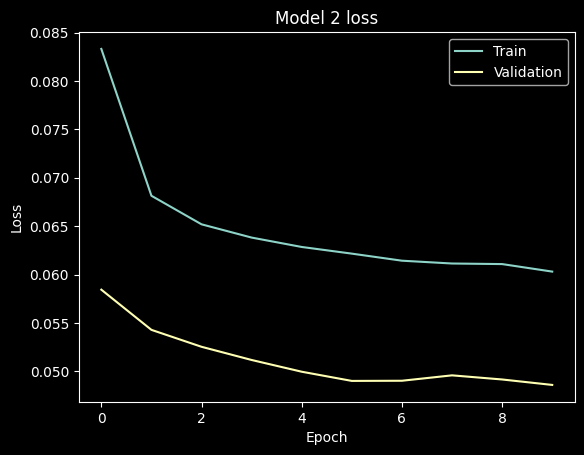

In [265]:
# Plot training & validation accuracy values
plt.plot(history_task2.history['accuracy'])
plt.plot(history_task2.history['val_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_task2.history['loss'])
plt.plot(history_task2.history['val_loss'])
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Task 3: Optimize the fall detection model 

Use optimization techniques to make your model as small and as quick as possible

To create a smaller and quicker model, knowledge distillation can be used. The idea is to train a model that serves as a student which learns the underlying patterns in the data by providing guidance to it from another more complex model called the "teacher". The goal of the student model is to retain as much of the teacher's model performance as possible, despite being less complex. 

The teacher model in this case is lstm_model_task2 because of it high accurancy. The student model, however, has fewer neurons per layer, fewer dense units per layer, and also lower dropout rate. The student model is then not only trained on the original dataset but also on the outputs of the teacher model. The outputs is referred to as soft labels. 

In [281]:
# Define the student model architecture
input_shape_student = X_train_reshape.shape[1:]
lstm_units_student = [30, 20]  # Fewer LSTM units
dense_units_student = [10, 5]  # Fewer Dense units
lstm_dropout_student = 0.2  # Lower dropout
dense_dropout_student = 0.2  # Lower dropout
output_activation_student = 'sigmoid'

# Create the student model
student_model = create_lstm_model(input_shape_student, lstm_units_student, dense_units_student, lstm_dropout_student, dense_dropout_student, output_activation_student)

# Compile the student model
student_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [282]:

# Train the student model using the soft labels
soft_labels = lstm_model_task2.predict(X_train_reshape)
student_history = student_model.fit(
    X_train_reshape, soft_labels, 
    epochs=10,
    batch_size=64,
    validation_data=(X_test_reshape, y_test),  
    verbose=1,
    callbacks=[early_stopping]
)

99878/99878 [==============================] - 66s 657us/step
Epoch 1/10
49939/49939 [==============================] - 71s 1ms/step - loss: 0.0755 - accuracy: 0.0000e+00 - val_loss: 0.0596 - val_accuracy: 0.9776
Epoch 2/10
49939/49939 [==============================] - 70s 1ms/step - loss: 0.0657 - accuracy: 0.0000e+00 - val_loss: 0.0579 - val_accuracy: 0.9783
Epoch 3/10
49939/49939 [==============================] - 69s 1ms/step - loss: 0.0644 - accuracy: 0.0000e+00 - val_loss: 0.0578 - val_accuracy: 0.9780
Epoch 4/10
49939/49939 [==============================] - 70s 1ms/step - loss: 0.0638 - accuracy: 0.0000e+00 - val_loss: 0.0569 - val_accuracy: 0.9786
Epoch 5/10
49939/49939 [==============================] - 69s 1ms/step - loss: 0.0634 - accuracy: 0.0000e+00 - val_loss: 0.0570 - val_accuracy: 0.9788
Epoch 6/10
49939/49939 [==============================] - 69s 1ms/step - loss: 0.0632 - accuracy: 0.0000e+00 - val_loss: 0.0570 - val_accuracy: 0.9786
Epoch 7/10
49939/49939 [========

In [289]:
test_loss_task3, test_accuracy_task3 = student_model.evaluate(X_test_reshape, y_test, verbose=0)
print(f"Test accuracy student: {test_accuracy_task3}, Test loss student: {test_loss_task3}")

Test accuracy student: 0.9791719913482666, Test loss student: 0.056021202355623245


In [284]:
# Classification report of the model 2 on test set
prediction_prob_task3 = student_model.predict(X_test_reshape)
prediction_task3 = (prediction_prob_task3 > 0.5).astype("int32")
print("Classification report of the student model on test set: \n", classification_report(y_test, prediction_task3))

24970/24970 [==============================] - 13s 506us/step
Classification report of the student model on test set: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    764438
           1       0.93      0.56      0.70     34582

    accuracy                           0.98    799020
   macro avg       0.95      0.78      0.85    799020
weighted avg       0.98      0.98      0.98    799020



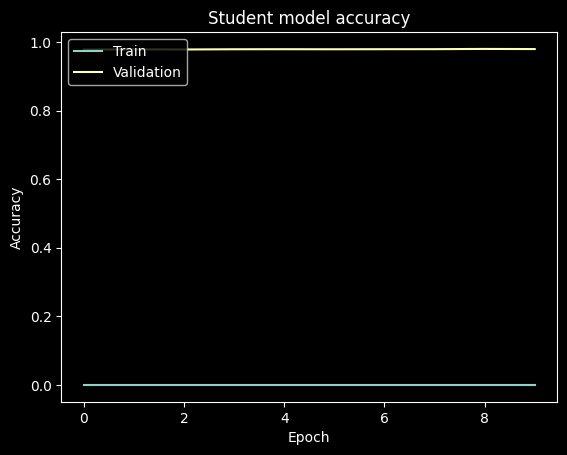

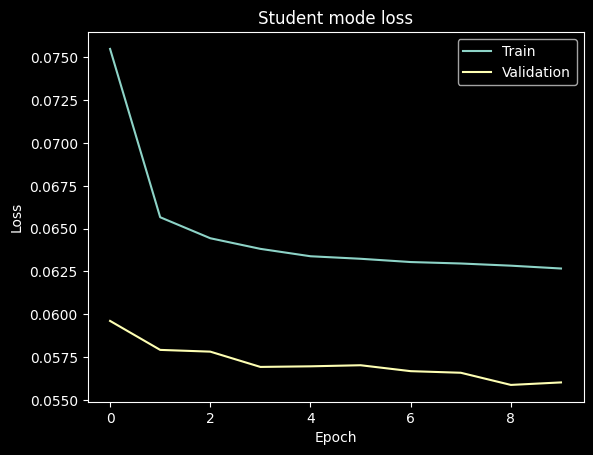

In [286]:
# Plot training & validation accuracy values
plt.plot(student_history.history['accuracy'])
plt.plot(student_history.history['val_accuracy'])
plt.title('Student model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(student_history.history['loss'])
plt.plot(student_history.history['val_loss'])
plt.title('Student mode loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Results and Discussion

## Task 1

To develop a neural network, LSTM design was applied to detect fall in human activity. The trained model showed high accuarcy but was created with only 10 epochs and two LSTM layers to minimize the run-time necessary to train the model. To improve accuracy and robustness of the model, increasing the epochs size and number of layers is recommended. Below is the test accuracy and the loss of the model: 

Test accuracy model 1: 0.98, Test loss model 1: 0.044.

## Task 2

The same approach for creating and traning the model for task 2 was used. A LSTM network was utilized but for this model, the batch size was increased from 32 to 64 from the previous model in task 1. An extra layer with 40 neurons were added, and an increase of the dropout rate from 0.2 to 0.3. The epochs, however, remained the same size to minimize run-time necessary to train the model. The increase of an extra layer can lead to increased overfitting but by adding a early stopping that will stop the traning if the validation accuarcy starts to decrease while the accuracy increases. An added early stopping and a increase in the dropout rate was necessary to avoid overfitting. Overall, the model 2 had a slightly increase in accuracy. Below is the test accuracy and the loss of the model: 

Test accuracy model 2: 0.98, Test loss model 2: 0.049.

## Task 3

To create a smaller and quicker, and yet keep the same efficency as the more larger and complex model, knowledge distillation was used.  The knowledge distillation is a technique where a larger and more complex model (teacher) is trained to provide guidance or instructions to a smaller and simpler model (student). The teacher model that was being used was the lstm_model_task2 because it had higher accuracy than lstm_model_task1. The student models's architecture was simplified to make it as small and quick as possible while still maintaining comparable performance with the teacher model. The trade-off that needed to be made here is between computational resources(time/energy) and accuracy of the model. In this case, the student model took less time to train but gave slightly lower accuracy compared to the teacher model. The accraucy, however, decreased with 1% but the time to train the student's model took 6 min less. The goal to make the model  lighter and faster without sacrificing too much in terms of accuracy was accomplished, but in cases where fall detection needs to be very precise, the student model might need furthur optimization. Below is the test accuracy and test loss of the student model: 

Test accuracy student: 0.98, Test loss student: 0.056.
